In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import (add_metpy_logo, simple_layout, StationPlot,
                         StationPlotLayout, wx_code_map)
from metpy.units import units

%matplotlib inline

In [3]:
# Read in the data
with get_test_data('station_data.txt') as f:
    data_arr = pd.read_csv(f, header=0, usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                           names=['stid', 'lat', 'lon', 'slp', 'air_temperature',
                                  'cloud_fraction', 'dew_point_temperature', 'weather',
                                  'wind_dir', 'wind_speed'],
                           na_values=-99999)

    data_arr.set_index('stid', inplace=True)

In [5]:
# Pull out these specific stations
selected = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
            'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
            'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
            'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
            'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

# Loop over all the whitelisted sites, grab the first data, and concatenate them
data_arr = data_arr.loc[selected]

# Drop rows with missing winds
data_arr = data_arr.dropna(how='any', subset=['wind_dir', 'wind_speed'])

# First, look at the names of variables that the layout is expecting:
simple_layout.names()

['eastward_wind',
 'northward_wind',
 'air_temperature',
 'dew_point_temperature',
 'air_pressure_at_sea_level',
 'cloud_coverage',
 'present_weather']

In [6]:
# This is our container for the data
data = {}

# Copy out to stage everything together. In an ideal world, this would happen on
# the data reading side of things, but we're not there yet.
data['longitude'] = data_arr['lon'].values
data['latitude'] = data_arr['lat'].values
data['air_temperature'] = data_arr['air_temperature'].values * units.degC
data['dew_point_temperature'] = data_arr['dew_point_temperature'].values * units.degC
data['air_pressure_at_sea_level'] = data_arr['slp'].values * units('mbar')

In [7]:
# Get the wind components, converting from m/s to knots as will be appropriate
# for the station plot
u, v = wind_components(data_arr['wind_speed'].values * units('m/s'),
                       data_arr['wind_dir'].values * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v

# Convert the fraction value into a code of 0-8, which can be used to pull out
# the appropriate symbol
data['cloud_coverage'] = (8 * data_arr['cloud_fraction']).fillna(10).values.astype(int)

# Map weather strings to WMO codes, which we can use to convert to symbols
# Only use the first symbol if there are multiple
wx_text = data_arr['weather'].fillna('')
data['present_weather'] = [wx_code_map[s.split()[0] if ' ' in s else s] for s in wx_text]

In [9]:
# Set up the map projection 
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

/usr/lib/python3/dist-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


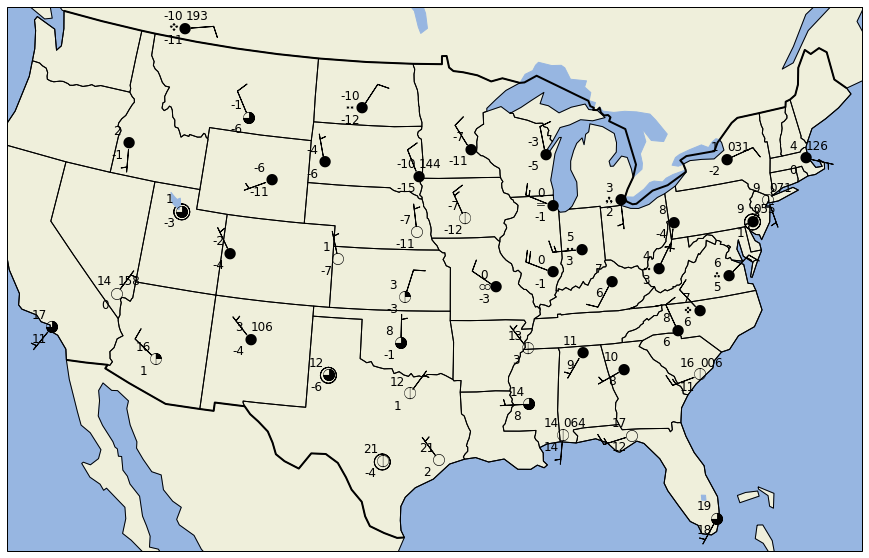

In [10]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection
fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 1080, 290, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)

plt.show()